In [1]:
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap


from utils import *
from ardca import *
from classes import *

In [2]:
N_SEQ = 1000

In [3]:
msa_path = "../data/PF00014.fasta.gz"
alignment = read_fasta_alignment(msa_path, max_gap_fraction=1.0)
alignment2d, _ = pca_from_onehot(alignment)

# Principal Components Analysis on Samples: Comparing the MSA Sequences with Model Generated Sequences

In [4]:
# sample from MSA
random_indices = np.random.choice(alignment2d.shape[0], size=N_SEQ, replace=False)
random_msa_samples = alignment2d[random_indices]

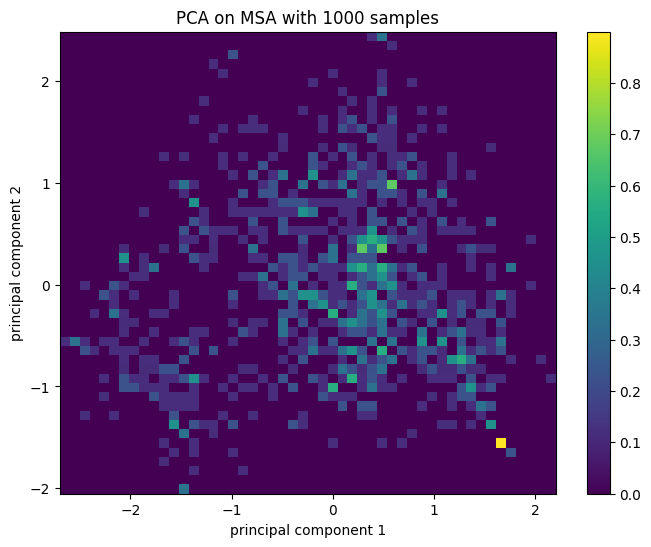

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
h = ax.hist2d(
    random_msa_samples[:, 0],
    random_msa_samples[:, 1],
    bins=50,
    density=True,
)

ax.set(
    title=f"PCA on MSA with {N_SEQ} samples",
    xlabel="principal component 1",
    ylabel="principal component 2",
)

plt.colorbar(h[3], ax=ax)
plt.show()

In [6]:
# sample sequences from model
model = load_ardca_model("models/ardca_PF00014_v2.pt")
generated_seqs = model.sample(n_samples=N_SEQ)

In [7]:
pca_generated, _ = pca_from_onehot(generated_seqs)

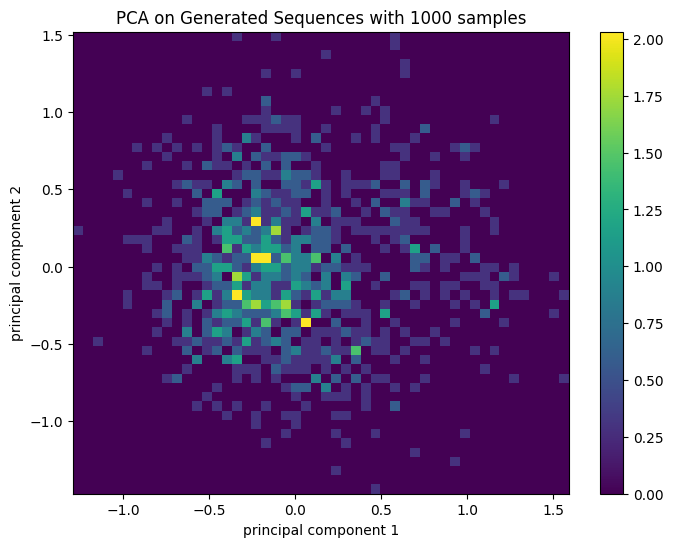

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
h = ax.hist2d(
    pca_generated[:, 0],
    pca_generated[:, 1],
    bins=50,
    density=True,
)

ax.set(
    title=f"PCA on Generated Sequences with {N_SEQ} samples",
    xlabel="principal component 1",
    ylabel="principal component 2",
)

plt.colorbar(h[3], ax=ax)
plt.show()

# UMAP

In [9]:
def umap_from_onehot(idx_mat: np.ndarray, n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean"):
    """
    Perform UMAP on one-hot encoded sequences.
    
    Args:
        idx_mat (np.ndarray): Integer matrix of shape (M, L).
        n_components (int): Number of embedding dimensions.
        n_neighbors (int): Size of local neighborhood (UMAP hyperparameter).
        min_dist (float): Minimum distance between points in low-dim space.
        metric (str): Distance metric (default: 'euclidean').
    
    Returns:
        Z (np.ndarray): UMAP embedding of shape (M, n_components).
        umap_model (umap.UMAP): Fitted UMAP object.
    """
    X = one_hot_for_pca(idx_mat)  # (M, L*q)
    reducer = umap.UMAP(
        init="random",
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )
    Z = reducer.fit_transform(X)
    return Z, reducer

/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


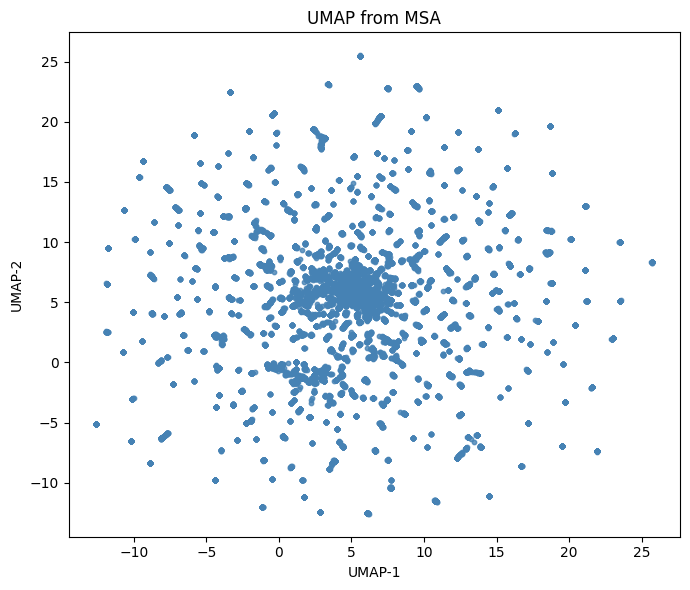

In [10]:
alignment_umap, _ = umap_from_onehot(alignment, n_components=2)
plt.figure(figsize=(7, 6))
plt.scatter(alignment_umap[:, 0], alignment_umap[:, 1], s=10, alpha=0.8, color="steelblue")

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP from MSA")
plt.tight_layout()
plt.show()

/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


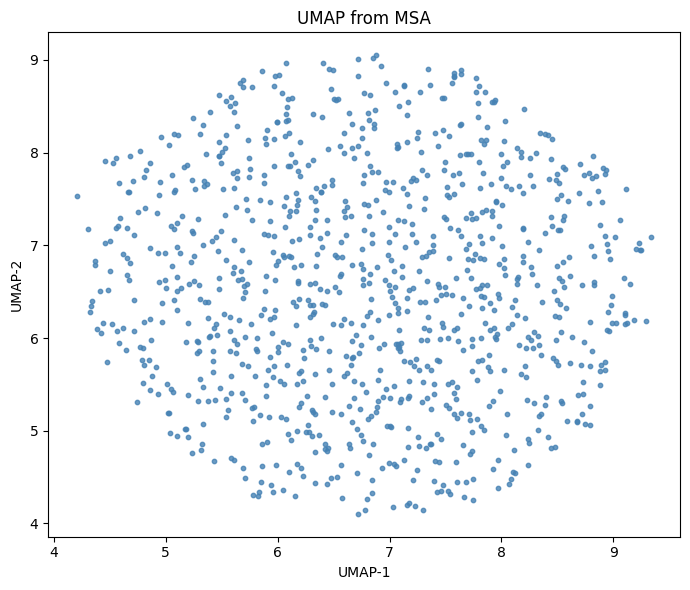

In [11]:
generated_umap, _ = umap_from_onehot(generated_seqs, n_components=2)

plt.figure(figsize=(7, 6))
plt.scatter(generated_umap[:, 0], generated_umap[:, 1], s=10, alpha=0.8, color="steelblue")

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP from MSA")
plt.tight_layout()
plt.show()

/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an un

<Figure size 1200x1000 with 0 Axes>

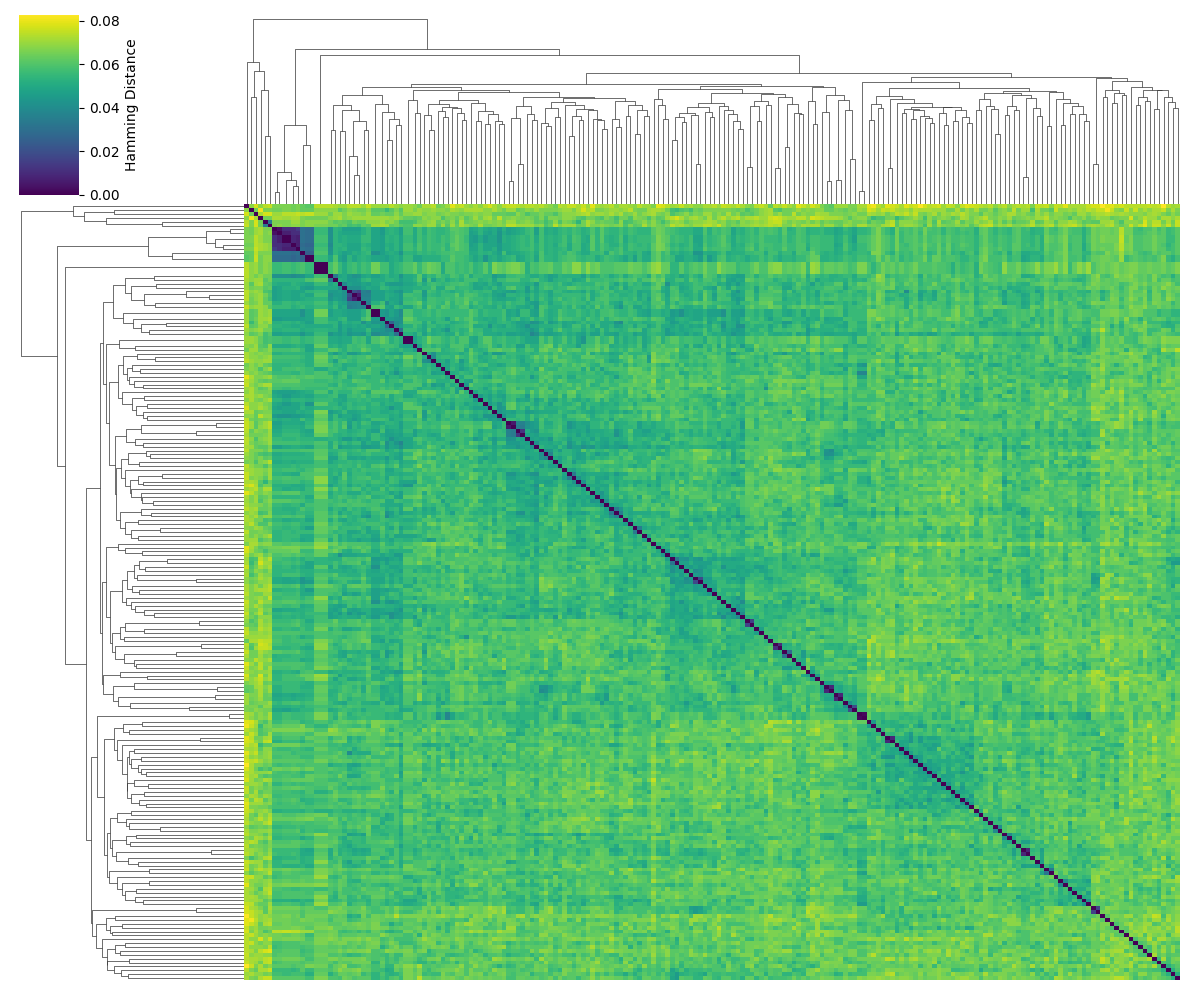

In [12]:
from sklearn.metrics import pairwise_distances
import seaborn as sns

N_SEQ = 200

random_indices = np.random.choice(alignment.shape[0], size=N_SEQ, replace=False)
random_msa_samples = alignment[random_indices]

X = one_hot_for_pca(random_msa_samples)
dist_matrix = pairwise_distances(X, metric="hamming")

plt.figure(figsize=(12, 10))
cluster_grid = sns.clustermap(
    dist_matrix,
    cmap="viridis",
    figsize=(12, 10),
    method="average",  # Use average linkage for clustering
    xticklabels=False, # Hide x-axis labels
    yticklabels=False, # Hide y-axis labels
    cbar_kws={"label": "Hamming Distance"}
)
plt.show()

/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an un

<Figure size 1200x1000 with 0 Axes>

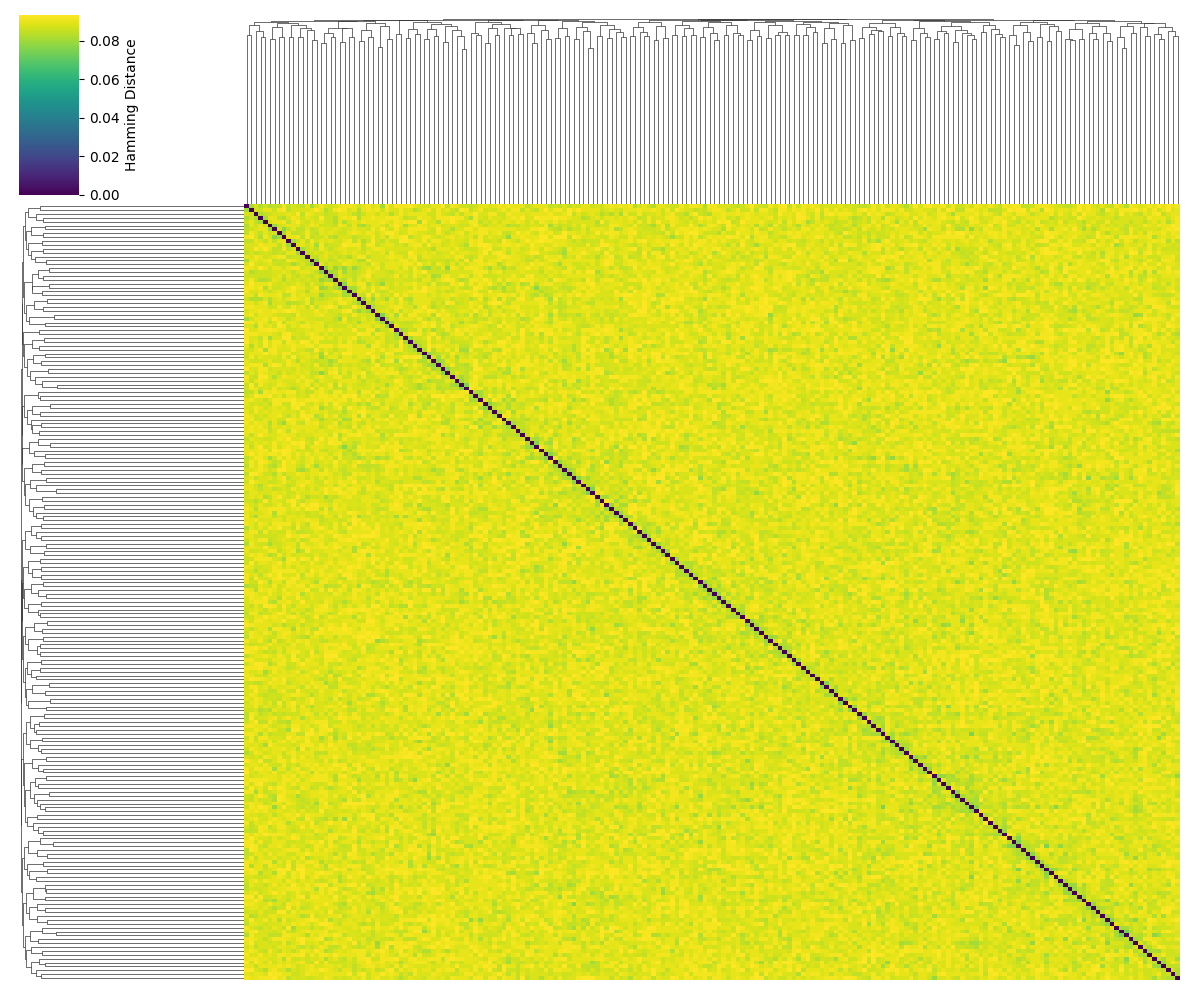

In [13]:
generated_seqs = model.sample(n_samples=N_SEQ)

Y = one_hot_for_pca(generated_seqs)
dist_matrix = pairwise_distances(Y, metric="hamming")

plt.figure(figsize=(12, 10))
cluster_grid = sns.clustermap(
    dist_matrix,
    cmap="viridis",
    figsize=(12, 10),
    method="average",  # Use average linkage for clustering
    xticklabels=False, # Hide x-axis labels
    yticklabels=False, # Hide y-axis labels
    cbar_kws={"label": "Hamming Distance"}
)
plt.show()

# Pearson Correlation Between Empirical and Model-Generated Connected Correlations 

In [14]:
# Calculate connected correlations for both MSA and generated sequences
def compute_connected_correlations(sequences):
    """
    Compute connected correlations (Cij) from sequences.
    """
    # Convert to one-hot encoding if not already
    if sequences.ndim == 2:
        one_hot = one_hot_for_pca(sequences)
    else:
        one_hot = sequences
    
    M, L_total = one_hot.shape
    q = 21  # Number of amino acids including gap
    L = L_total // q
    
    # Reshape to (M, L, q)
    x = one_hot.reshape(M, L, q)
    
    # Calculate frequencies (1-point)
    fi = x.mean(axis=0)  # Shape (L, q)
    
    # Calculate pair frequencies (2-point)
    fij = np.zeros((L, L, q, q))
    for i in range(L):
        for j in range(i+1, L):
            for a in range(M):
                for qi in range(q):
                    for qj in range(q):
                        if x[a, i, qi] > 0 and x[a, j, qj] > 0:
                            fij[i, j, qi, qj] += 1
    fij /= M
    
    # Calculate connected correlations
    cij = np.zeros((L, L, q, q))
    for i in range(L):
        for j in range(i+1, L):
            for qi in range(q):
                for qj in range(q):
                    cij[i, j, qi, qj] = fij[i, j, qi, qj] - fi[i, qi] * fi[j, qj]
    
    return cij

In [15]:
# Calculate connected correlations for both datasets
# Use sample of MSA sequences to match the number of generated sequences
msa_sample = alignment[:N_SEQ]
msa_one_hot = one_hot_for_pca(msa_sample)
gen_one_hot = one_hot_for_pca(generated_seqs)

# Compute connected correlations
msa_cij = compute_connected_correlations(msa_sample)
gen_cij = compute_connected_correlations(generated_seqs)

# Flatten the connected correlation matrices for correlation calculation
msa_cij_flat = []
gen_cij_flat = []
L = msa_sample.shape[1]
q = 21

for i in range(L):
    for j in range(i+1, L):
        for qi in range(q):
            for qj in range(q):
                msa_cij_flat.append(msa_cij[i, j, qi, qj])
                gen_cij_flat.append(gen_cij[i, j, qi, qj])

msa_cij_flat = np.array(msa_cij_flat)
gen_cij_flat = np.array(gen_cij_flat)

# Calculate Pearson correlation
from scipy.stats import pearsonr
corr, pval = pearsonr(msa_cij_flat, gen_cij_flat)

print(f"Pearson correlation between MSA and generated connected correlations: {corr:.4f}")
print(f"p-value: {pval:.4e}")

Pearson correlation between MSA and generated connected correlations: 0.0016
p-value: 2.0410e-01


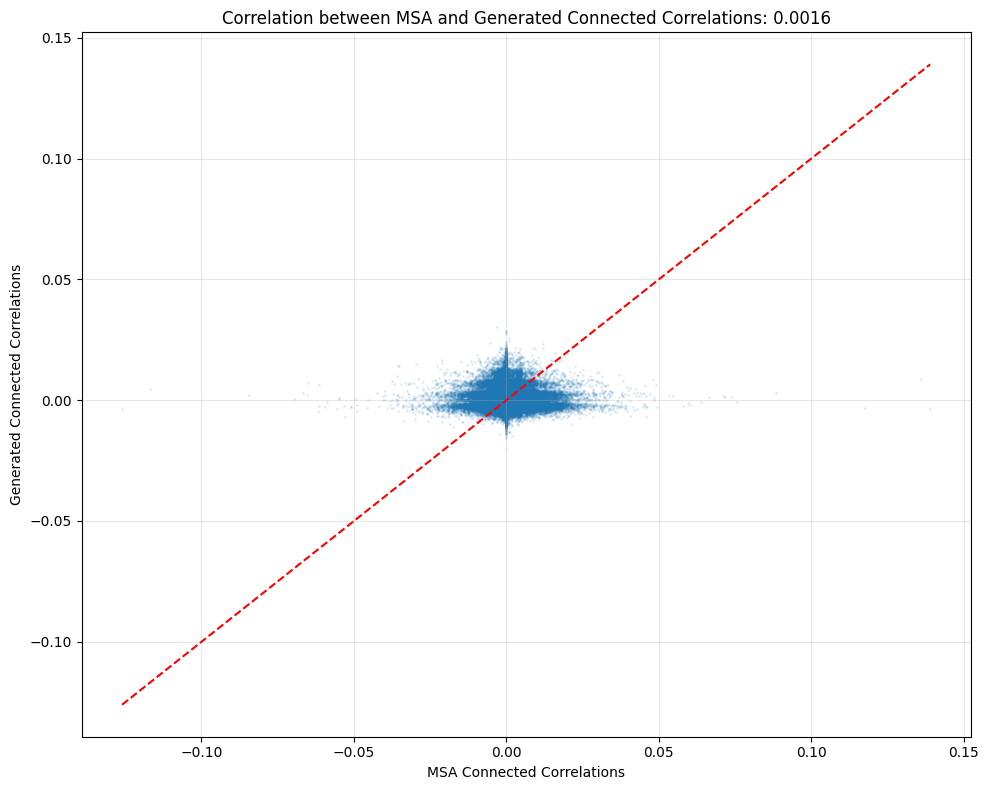

In [16]:
# Visualize the correlation
plt.figure(figsize=(10, 8))
plt.scatter(msa_cij_flat, gen_cij_flat, alpha=0.1, s=1)
plt.xlabel("MSA Connected Correlations")
plt.ylabel("Generated Connected Correlations")
plt.title(f"Correlation between MSA and Generated Connected Correlations: {corr:.4f}")

# Add diagonal line for perfect correlation
min_val = min(msa_cij_flat.min(), gen_cij_flat.min())
max_val = max(msa_cij_flat.max(), gen_cij_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()